<a href="https://colab.research.google.com/github/hardikroutray/ECG/blob/main/CNN2D_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries or install unavailable libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
%pylab inline
%config InlineBackend.figure_formats = ['retina']
from imutils import paths
import time   # time1 = time.time(); print('Time taken: {:.1f} sec'.format(time.time() - time1))
import cv2
import pickle
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from sklearn.metrics import plot_confusion_matrix

# **Mount google drive with cropped images**

In [5]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/MyDrive', force_remount=True)
!ls /content/MyDrive/MyDrive/ECG/data_v2/

unset HISTFILE; export PS1="root@26d12269733b-bc2a916dc46e489ba3e6ad1a6b5ebff1: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@26d12269733b-bc2a916dc46e489ba3e6ad1a6b5ebff1: umount -f /content/MyDrive || umount /content/MyDrive; pkill -9 -x drive
umount: /content/MyDrive: no mount point specified.
umount: /content/MyDrive: no mount point specified.
root@26d12269733b-bc2a916dc46e489ba3e6ad1a6b5ebff1: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@26d12269733b-bc2a916dc46e489ba3e6ad1a6b5ebff1: ( while `sleep 0.5`; do if [[ -d "/content/MyDrive" && "$(ls -A /content/MyDrive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 117
root@26d12269733b-bc2a916dc46e489ba3e6ad1a6b5ebff1: cat /tmp/tmp7l54t7q8/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task

# **Display an example cropped image after resizing and do sanity check after converting it to np array** 




<class 'PIL.Image.Image'>
None
L
(150, 150)


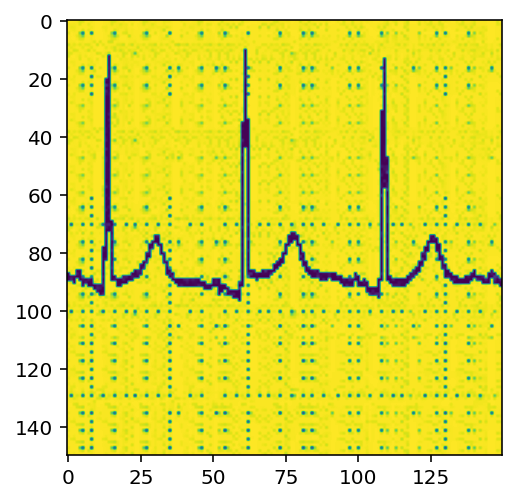

In [5]:
img = image.load_img('/content/MyDrive/MyDrive/ECG/data_v2/NormalPersonECGImages/Cropped_Images/Normal_100Cropped_lead4.png', grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True

print(type(img))
print(img.format)
print(img.mode)
print(img.size)
# show the image
plt.imshow(img)

In [ ]:
img_array = image.img_to_array(img)
print(img_array.dtype)
print(img_array.shape)
img_back = image.array_to_img(img_array)
# plt.imshow(img_back)

float32
(150, 150, 1)


# **Make a dataframe with first column as the path to images and the second column as the labels** 


*   Use ECG lead 2(named 4 while cropping) to classify. 
*   Use other leads as separate viewpoints later for e.g an ensemble method



In [6]:
import os

images = []
labels = []

dirs = ['ECGImagesofMyocardialInfarctionPatients', 'ECGImagesofPatientthathaveabnormalheartbeat', 'ECGImagesofPatientthathaveHistoryofMI', 'NormalPersonECGImages']

for dir in dirs:
  print(dir)
  for filename in os.listdir('/content/MyDrive/MyDrive/ECG/data_v2/{}/Cropped_Images/'.format(dir)):
    if filename.endswith("png") and "lead4" in filename: 
      # print(dir,filename)
      images.append('/content/MyDrive/MyDrive/ECG/data_v2/{}/Cropped_Images/{}'.format(dir,filename))
      # if dir == 'ECGImagesofCOVID-19Patients':
      #   labels.append(1)
      if dir == 'ECGImagesofMyocardialInfarctionPatients':
        labels.append(1)
      elif dir == 'ECGImagesofPatientthathaveabnormalheartbeat':
        labels.append(2)
      elif dir == 'ECGImagesofPatientthathaveHistoryofMI':
        labels.append(3)
      elif dir == 'NormalPersonECGImages':
        labels.append(0)

df = pd.DataFrame({"image":images, "label":labels})
df
df.to_csv("ECG_cropped_lead4.csv", index=False)
!cp "ECG_cropped_lead4.csv" "/content/MyDrive/MyDrive/ECG/"

ECGImagesofMyocardialInfarctionPatients
ECGImagesofPatientthathaveabnormalheartbeat
ECGImagesofPatientthathaveHistoryofMI
NormalPersonECGImages


In [7]:
df

,image,label
0,/content/MyDrive/MyDrive/ECG/data_v2/ECGImages...,1
1,/content/MyDrive/MyDrive/ECG/data_v2/ECGImages...,1
2,/content/MyDrive/MyDrive/ECG/data_v2/ECGImages...,1
3,/content/MyDrive/MyDrive/ECG/data_v2/ECGImages...,1
4,/content/MyDrive/MyDrive/ECG/data_v2/ECGImages...,1
...,...,...
923,/content/MyDrive/MyDrive/ECG/data_v2/NormalPer...,0
924,/content/MyDrive/MyDrive/ECG/data_v2/NormalPer...,0
925,/content/MyDrive/MyDrive/ECG/data_v2/NormalPer...,0
926,/content/MyDrive/MyDrive/ECG/data_v2/NormalPer...,0


# **Process all images into np arrays and divide into training and test dataset, build the model and train your network**

> Indented block



*   Resizes to (150,150)
*   Uses grayscale since color is irrelevant in ECG classification
*   The higher the resolution, the longer it takes to train and could take up a lot of RAM and disk (find optimal crossover!)
*   Scale by 255 to nromalize





In [8]:
imagedata = []
for i in tqdm(range(df.shape[0])):
    img = image.load_img('{}'.format(df["image"][i]), target_size=(150,150,1), grayscale=True) #, grayscale=True
    img = image.img_to_array(img)
    img = img/255
    imagedata.append(img)
X = np.array(imagedata)

100%|██████████| 928/928 [03:00<00:00,  5.14it/s]




*   **One hot encoding**





In [10]:
y=df['label'].values
y = to_categorical(y) #one-hot encoding


* **Save your processed image arrays into npy files to not repeat the above steps later.**



In [11]:
np.save('X_data_v2_croppedimages_lead4_150150.npy', X)
!cp "X_data_v2_croppedimages_lead4_150150.npy" "/content/MyDrive/MyDrive/ECG/"

np.save('y_data_v2_croppedimages_lead4_150150.npy', y)
!cp "y_data_v2_croppedimages_lead4_150150.npy" "/content/MyDrive/MyDrive/ECG/"

In [6]:
X_load = np.load('/content/MyDrive/MyDrive/ECG/X_data_v2_croppedimages_lead4_150150.npy')
y_load = np.load('/content/MyDrive/MyDrive/ECG/y_data_v2_croppedimages_lead4_150150.npy')


*   **Divide into training and test set after stratifying**



In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_load, y_load, random_state=100, test_size=0.2, shuffle=True, stratify=y_load)

**Make a model**

In [72]:
# model = Sequential()
# model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(4, activation='softmax'))


model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',input_shape=(150,150,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


In [73]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 148, 148, 128)     1280      
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 146, 146, 64)      73792     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 71, 71, 32)        18464     
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 69, 69, 32)        9248      
_________________________________________________________________
flatten_27 (Flatten)         (None, 152352)            0         
_________________________________________________________________
dense_82 (Dense)             (None, 64)              

In [74]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [75]:
history=model.fit(X_train, y_train, epochs=17, validation_data=(X_test, y_test))

Epoch 1/17
24/24 [==============================] - 4s 118ms/step - loss: 1.7731 - accuracy: 0.2612 - val_loss: 1.4035 - val_accuracy: 0.2527
Epoch 2/17
24/24 [==============================] - 2s 102ms/step - loss: 1.3922 - accuracy: 0.2908 - val_loss: 1.2632 - val_accuracy: 0.5806
Epoch 3/17
24/24 [==============================] - 2s 101ms/step - loss: 1.0752 - accuracy: 0.5696 - val_loss: 0.7090 - val_accuracy: 0.7688
Epoch 4/17
24/24 [==============================] - 2s 102ms/step - loss: 0.4973 - accuracy: 0.8218 - val_loss: 0.4348 - val_accuracy: 0.8172
Epoch 5/17
24/24 [==============================] - 2s 102ms/step - loss: 0.1237 - accuracy: 0.9545 - val_loss: 0.3446 - val_accuracy: 0.9140
Epoch 6/17
24/24 [==============================] - 2s 102ms/step - loss: 0.0569 - accuracy: 0.9806 - val_loss: 0.4649 - val_accuracy: 0.8817
Epoch 7/17
24/24 [==============================] - 2s 103ms/step - loss: 0.0091 - accuracy: 0.9987 - val_loss: 0.4711 - val_accuracy: 0.9086
Epoch 

**Save Model** 

In [95]:
model.save("bestCNN2D.h5") 

In [96]:
!cp bestCNN2D.h5 "/content/MyDrive/MyDrive/ECG/"

**Test Loss and Accuracy** 

In [76]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7240768671035767
Test accuracy: 0.9032257795333862


In [77]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


**Training and Validation Loss**

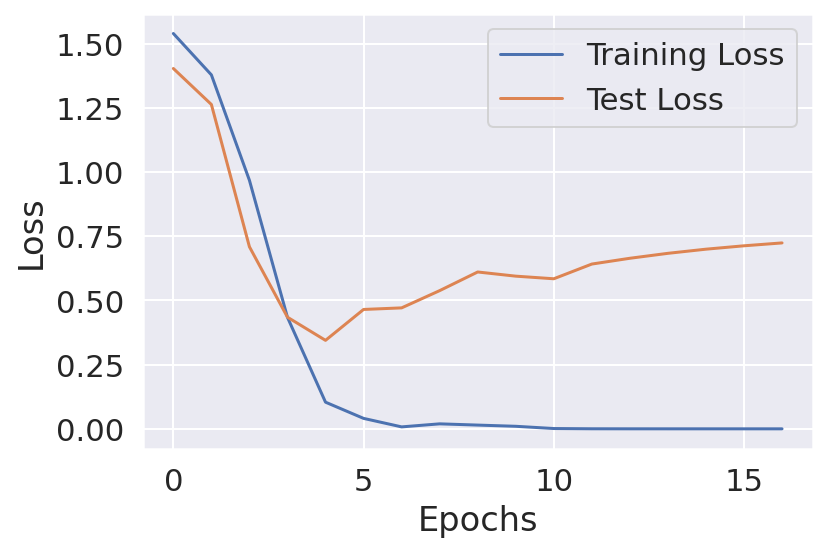

In [137]:
plt.plot(history.history['loss'],label="Training Loss")
plt.plot(history.history['val_loss'],label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss_2DCNN.png", dpi=300, bbox_inches="tight")
!cp "Loss_2DCNN.png" "/content/MyDrive/MyDrive/ECG/"

**Training and Validation Accuracy**

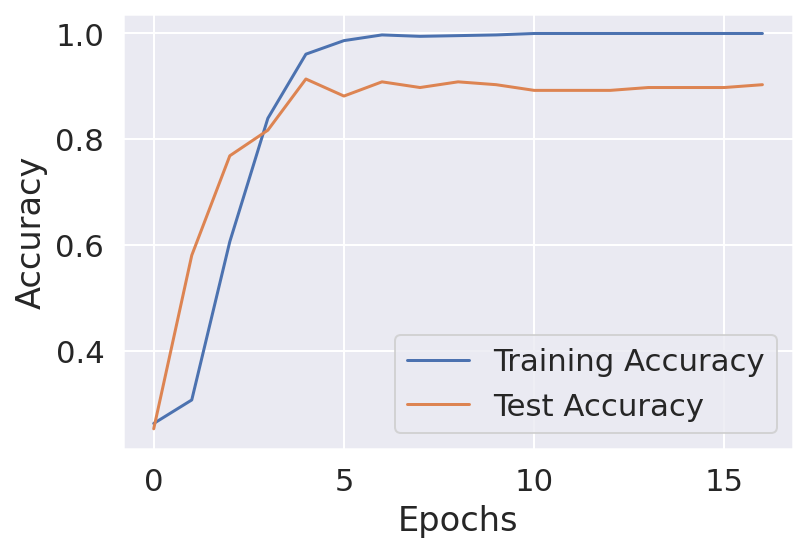

In [136]:
plt.plot(history.history['accuracy'],label="Training Accuracy")
plt.plot(history.history['val_accuracy'],label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("Accuracy_2DCNN.png", dpi=300, bbox_inches="tight")
!cp "Accuracy_2DCNN.png" "/content/MyDrive/MyDrive/ECG/"

In [80]:
import sklearn.metrics as metrics

y_test_pred = model.predict(X_test)  
y_test_pred_labels = np.argmax(y_test_pred, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
# print(y_test_pred_labels)
y_test_labels = np.argmax(y_test, axis=1)
# print(y_test_labels)
confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=y_test_pred_labels) 

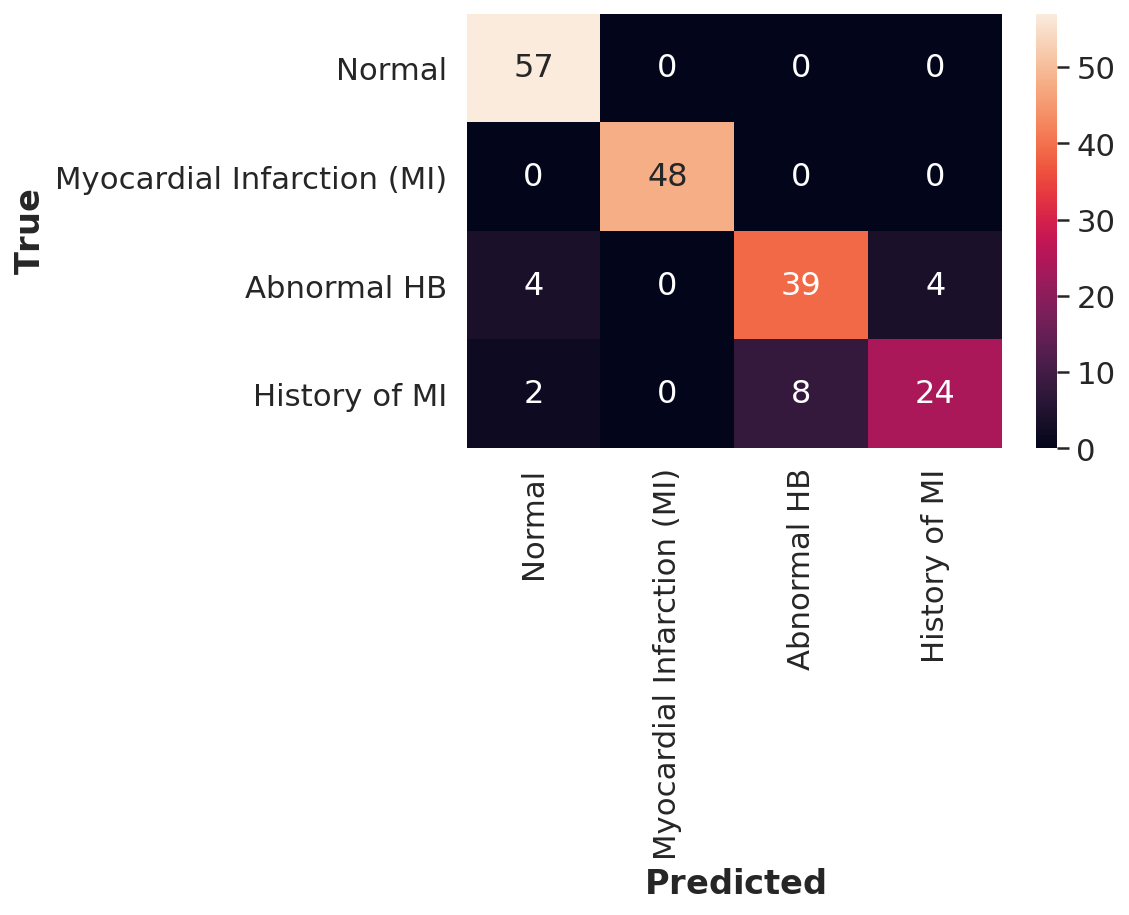

In [134]:
x_axis_labels = ["Normal", "Myocardial Infarction (MI)", "Abnormal HB", "History of MI"]
y_axis_labels = ["Normal", "Myocardial Infarction (MI)", "Abnormal HB", "History of MI"]

df_cm = pd.DataFrame(confusion_matrix, range(4), range(4))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g',xticklabels=x_axis_labels, yticklabels=y_axis_labels) # font size

plt.xlabel(r"$\bf{Predicted}$")
plt.ylabel(r"$\bf{True}$")

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# red_patch = mpatches.Patch(color=None, label='The red data')
# blue_patch = mpatches.Patch(color='blue', label='The blue data')

# plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.25, 1), loc='upper left')
# plt.tight_layout()
plt.savefig("Confusion_matrix_2DCNN.png", dpi=300, bbox_inches="tight")

plt.show()

!cp "Confusion_matrix_2DCNN.png" "/content/MyDrive/MyDrive/ECG/"

In [140]:
from sklearn.metrics import classification_report

df = pd.DataFrame(classification_report(y_test_pred_labels, 
                                        y_test_labels, digits=2,
                                        output_dict=True)).T
df['support'] = df.support.apply(int)
df.rename(index={'0':'Normal', '1':'Myocardial Infarction (MI)', '2':'Abnormal HB', '3':'History of MI'}, inplace=True)
df = df[0:4]
df.style.background_gradient(cmap='viridis')

# from pandas.plotting import table 

# ax = plt.subplot(111, frame_on=False) # no visible frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis

# table(ax, df)  # where df is your data frame

# plt.savefig('Scores_2DCNN.png',dpi=300)
# !cp "Scores_2DCNN.png" "/content/MyDrive/MyDrive/ECG/"

,precision,recall,f1-score,support
Normal,1.000000,0.904762,0.950000,63
Myocardial Infarction (MI),1.000000,1.000000,1.000000,48
Abnormal HB,0.829787,0.829787,0.829787,47
History of MI,0.705882,0.857143,0.774194,28


In [111]:
# from sklearn.metrics import precision_recall_curve
# precision, recall, thresholds = precision_recall_curve(y_test,y_test_pred)
# plt.step(recall, precision, color='b', alpha=0.2,
#          where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])

# **Play with feature maps and filter images as a sanity check to show that only the ECG line features are being used to classify instead of other irrelevant image features**

**Print Model Layers as a sanity check before playing with feature maps**

In [100]:
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_83 (3, 3, 1, 128)
conv2d_84 (3, 3, 128, 64)
conv2d_85 (3, 3, 64, 32)
conv2d_86 (3, 3, 32, 32)


**Show the filters used sequentially**

conv2d_83 (3, 3, 1, 128)
128


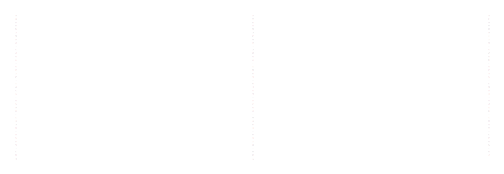

conv2d_84 (3, 3, 128, 64)
64


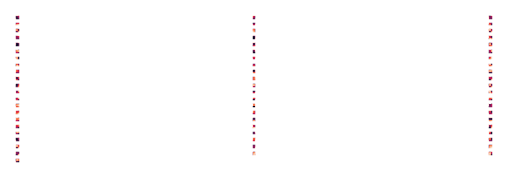

conv2d_85 (3, 3, 64, 32)
32


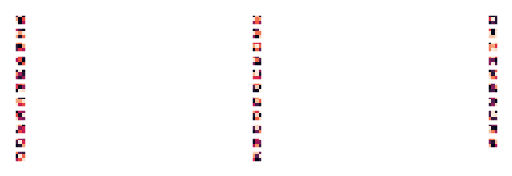

conv2d_86 (3, 3, 32, 32)
32


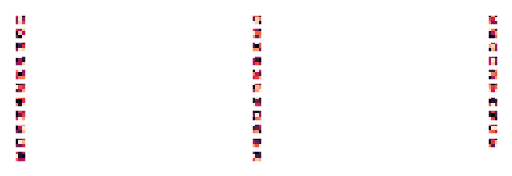

In [101]:
#Iterate thru all the layers of the model
layer_num=0
for layer in model.layers:
    layer_num+=1
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, weights.shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        

        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(1):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        # plt.savefig("filter_layer{}.png".format(layer_num), dpi=300)

        plt.show()
        
# !cp "filter_layer1.png" "/content/MyDrive/MyDrive/ECG/" 
# !cp "filter_layer2.png" "/content/MyDrive/MyDrive/ECG/" 
# !cp "filter_layer3.png" "/content/MyDrive/MyDrive/ECG/" 

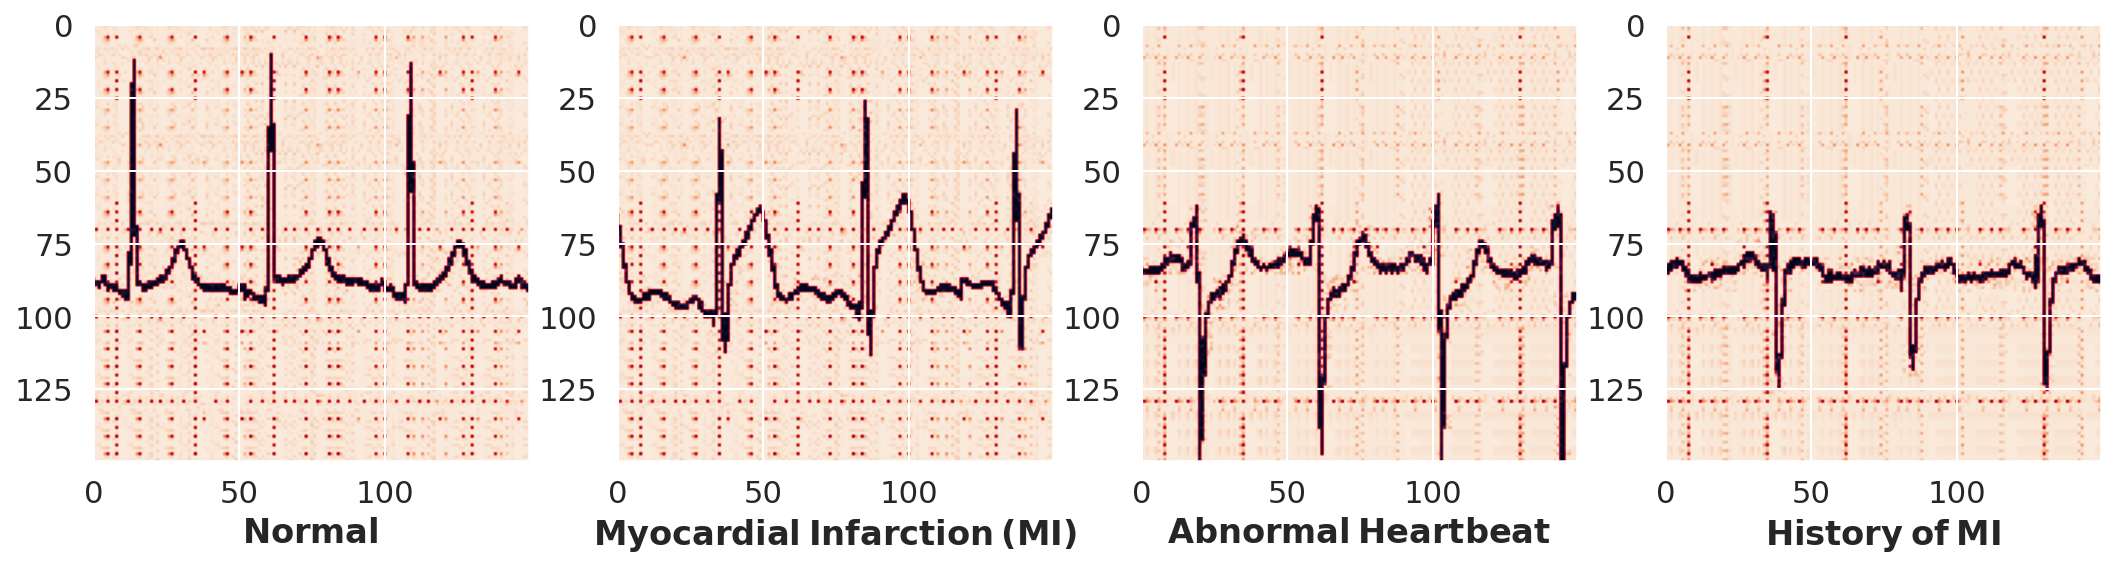

In [181]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 5))
img0 = image.load_img('/content/MyDrive/MyDrive/ECG/data_v2/NormalPersonECGImages/Cropped_Images/Normal_100Cropped_lead4.png', grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True
ax1.imshow(img0)
ax1.set_xlabel(r"$\bf{Normal}$")
img1 = image.load_img('/content/MyDrive/MyDrive/ECG/data_v2/ECGImagesofMyocardialInfarctionPatients/Cropped_Images/MI_20Cropped_lead4.png', grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True
ax2.imshow(img1)
ax2.set_xlabel(r"$\bf{Myocardial\: Infarction\:  (MI)}$")
img2 = image.load_img('/content/MyDrive/MyDrive/ECG/data_v2/ECGImagesofPatientthathaveabnormalheartbeat/Cropped_Images/HB_20Cropped_lead4.png', grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True
ax3.imshow(img2)
ax3.set_xlabel(r"$\bf{Abnormal\:  Heartbeat}$")
img3 = image.load_img('/content/MyDrive/MyDrive/ECG/data_v2/ECGImagesofPatientthathaveHistoryofMI/Cropped_Images/PMI_20Cropped_lead4.png', grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True
ax4.imshow(img3)
ax4.set_xlabel(r"$\bf{History\:  of\:  MI}$")

fig.savefig("representative_ECG_images.png",dpi=300)
! cp "representative_ECG_images.png" "/content/MyDrive/MyDrive/ECG/"

# **Helper function to display feature map of each CNN layer**

In [202]:
def showfeaturemap(img_path='/content/MyDrive/MyDrive/ECG/data_v2/ECGImagesofMyocardialInfarctionPatients/Cropped_Images/MI_1Cropped_lead4.png'):

  # Output= intermediate representations for all layers in the  
  # previous model after the first.
  successive_outputs = [layer.output for layer in model.layers[0:]]
  #visualization_model = Model(img_input, successive_outputs)
  visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
  #Load the input image
  img = load_img(img_path, target_size=(150, 150), grayscale=True)
  # Convert ht image to Array of dimension (150,150,3)
  x   = img_to_array(img)                           
  x   = x.reshape((1,) + x.shape)

  print(x.shape)
  # Rescale by 1/255
  x /= 255.0
  # Let's run input image through our vislauization network
  # to obtain all intermediate representations for the image.
  successive_feature_maps = visualization_model.predict(x)
  # Retrieve are the names of the layers, so can have them as part of our plot
  layer_names = [layer.name for layer in model.layers]
  for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    # print(feature_map.shape)
    if len(feature_map.shape) == 4:
    
      # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
      n_features = feature_map.shape[-1]  # number of features in the feature map
      size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
      # We will tile our images in this matrix
      display_grid = np.zeros((size, size * n_features))
    
      # Postprocess the feature to be visually palatable
      for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        # Tile each filter into a horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
      scale = 20. / n_features
      plt.figure( figsize=(scale * n_features, scale) )
      plt.title ( layer_name )
      plt.grid  ( False )
      plt.imshow( display_grid, aspect='auto', cmap='viridis' )


(1, 150, 150, 1)


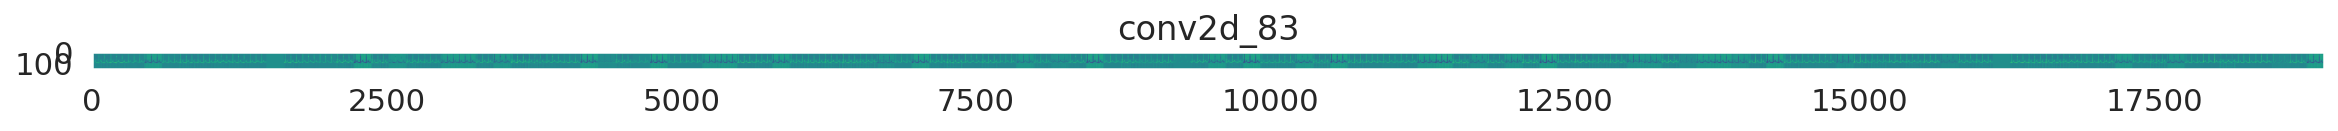

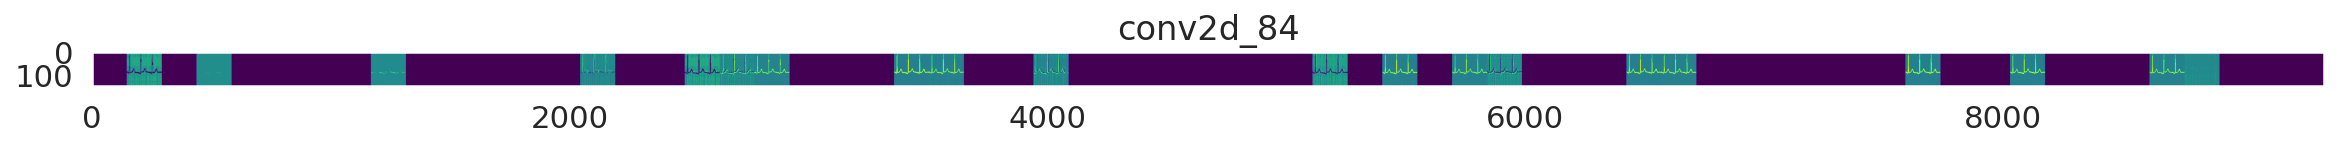

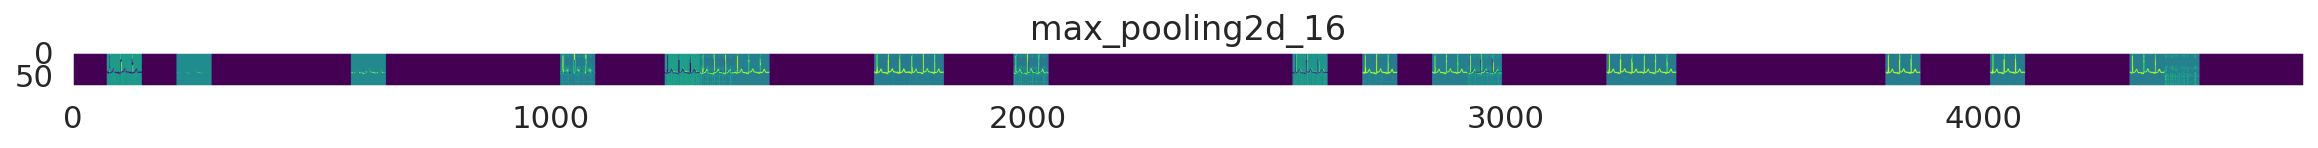

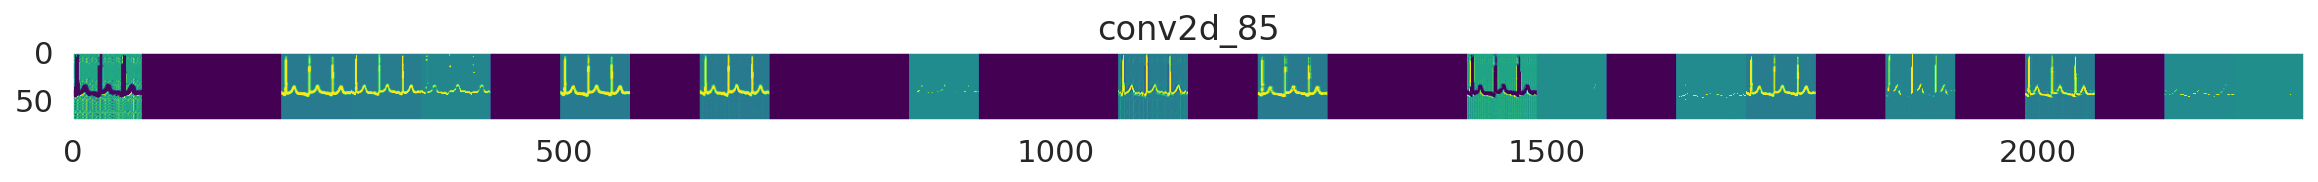

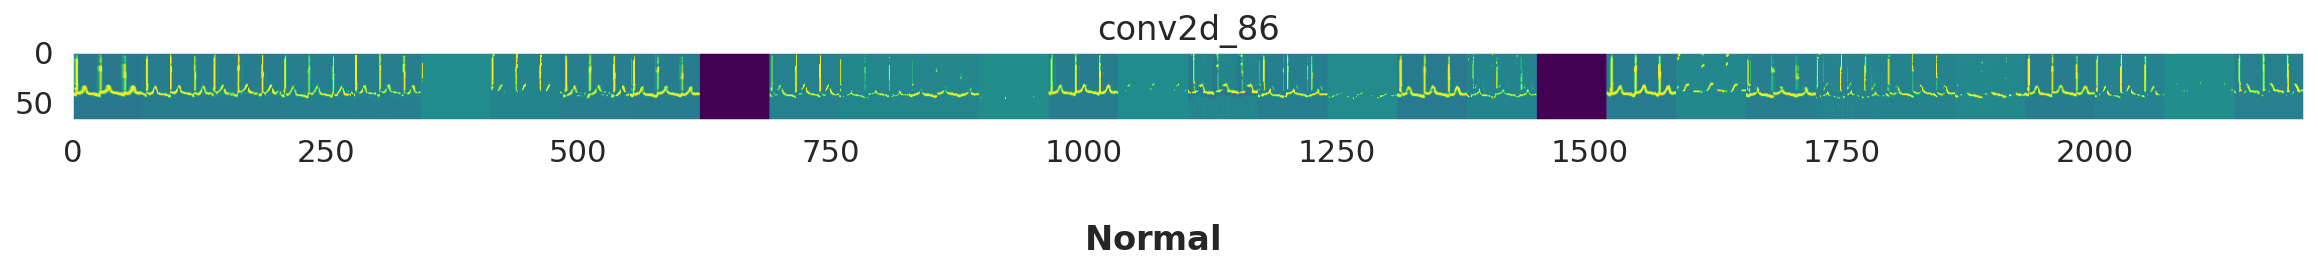

In [203]:
showfeaturemap('/content/MyDrive/MyDrive/ECG/data_v2/NormalPersonECGImages/Cropped_Images/Normal_100Cropped_lead4.png')
plt.text(1000,200,r"$\bf{Normal}$")
plt.show()

(1, 150, 150, 1)


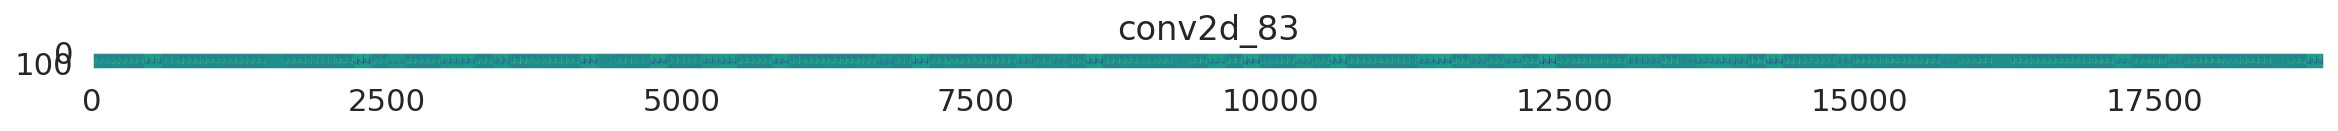

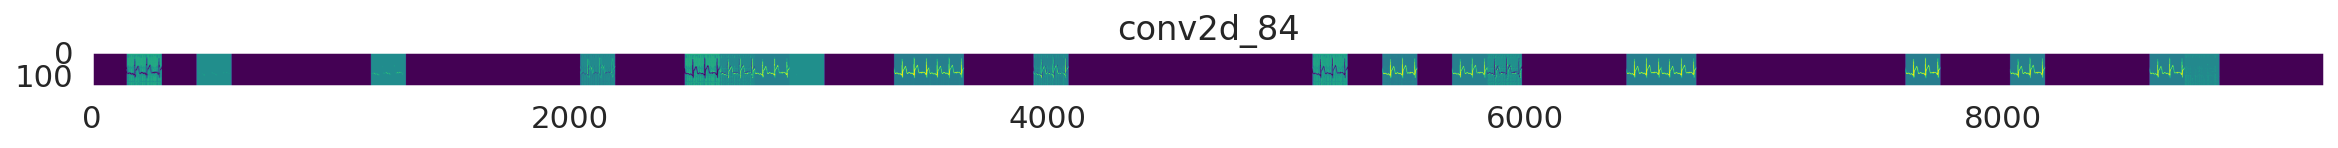

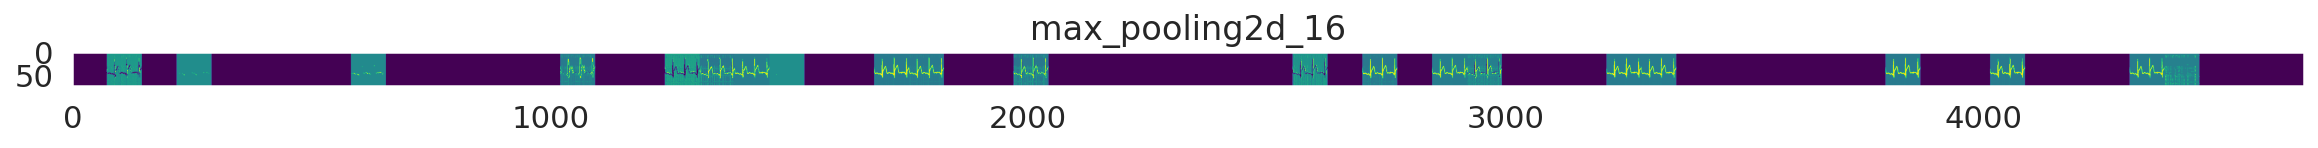

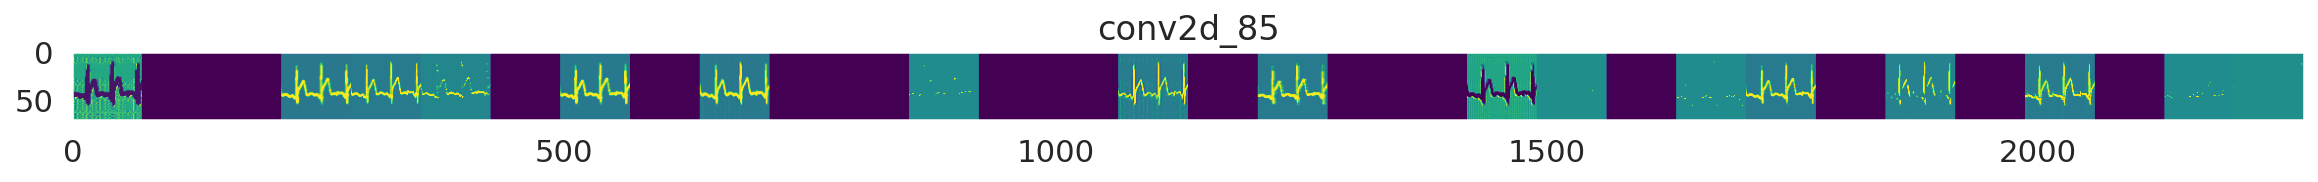

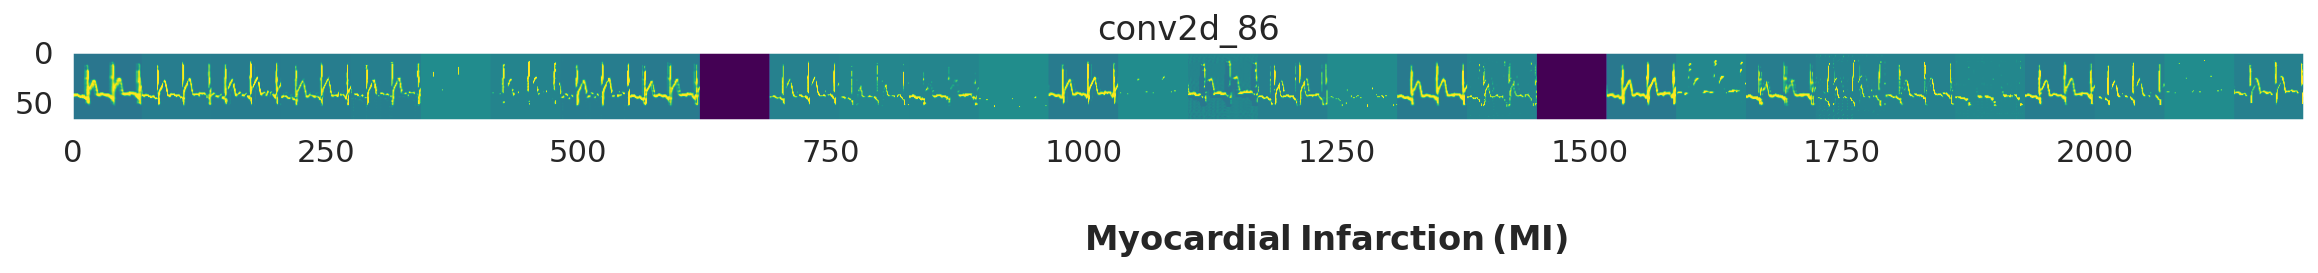

In [204]:
showfeaturemap('/content/MyDrive/MyDrive/ECG/data_v2/ECGImagesofMyocardialInfarctionPatients/Cropped_Images/MI_20Cropped_lead4.png')
plt.text(1000,200,r"$\bf{Myocardial\: Infarction\: (MI)}$")
plt.show()


(1, 150, 150, 1)


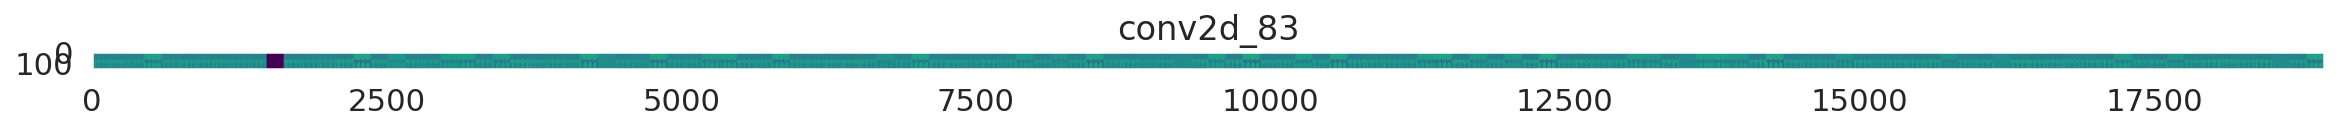

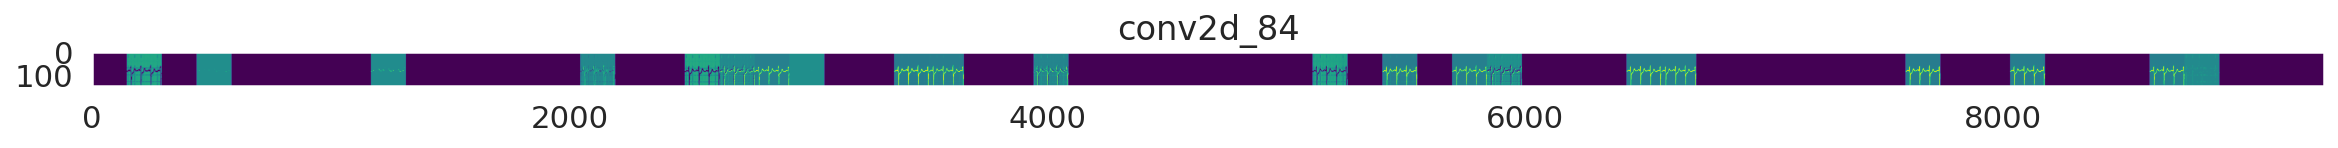

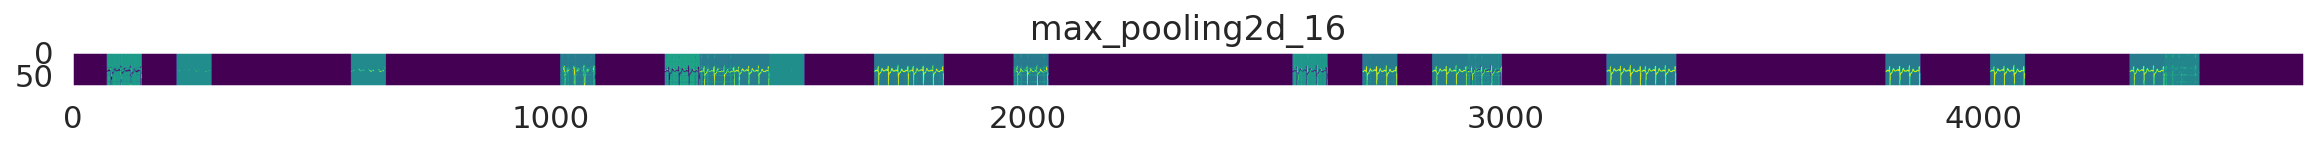

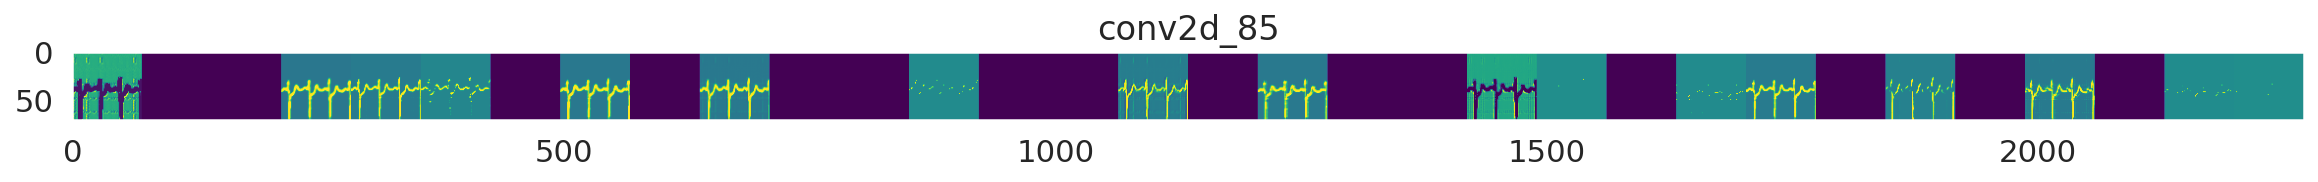

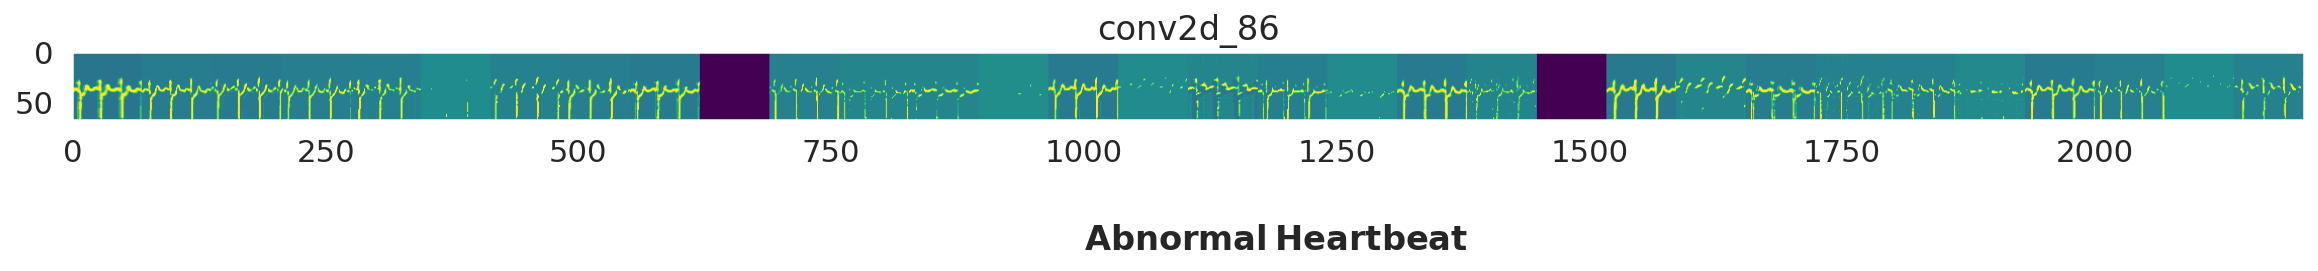

In [205]:
showfeaturemap('/content/MyDrive/MyDrive/ECG/data_v2/ECGImagesofPatientthathaveabnormalheartbeat/Cropped_Images/HB_20Cropped_lead4.png')
plt.text(1000,200,r"$\bf{Abnormal\: Heartbeat}$")
plt.show()

(1, 150, 150, 1)


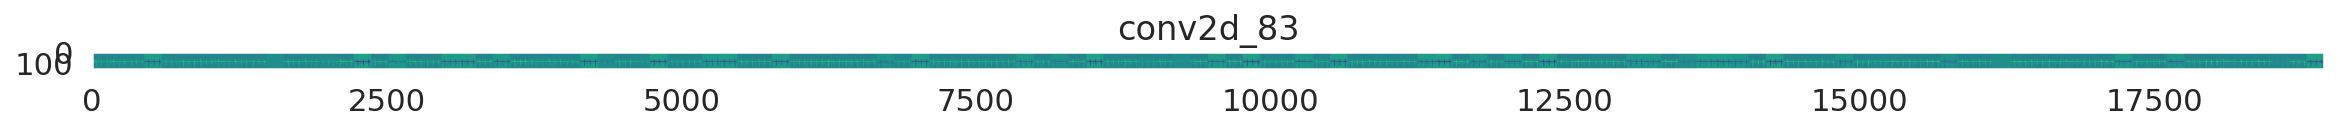

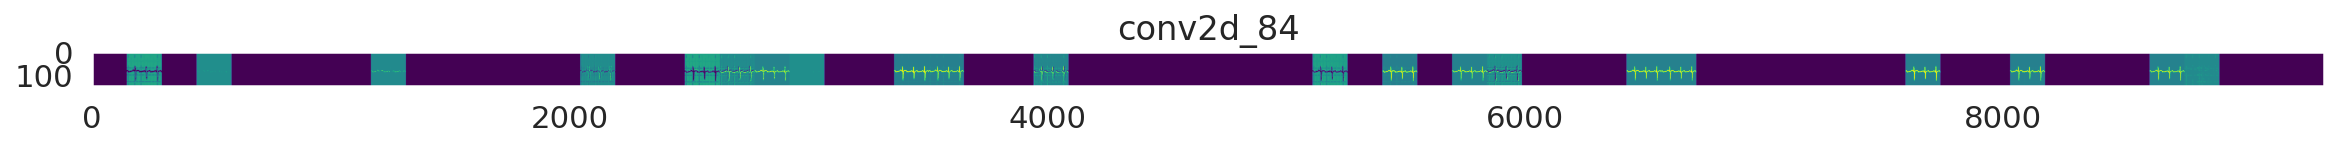

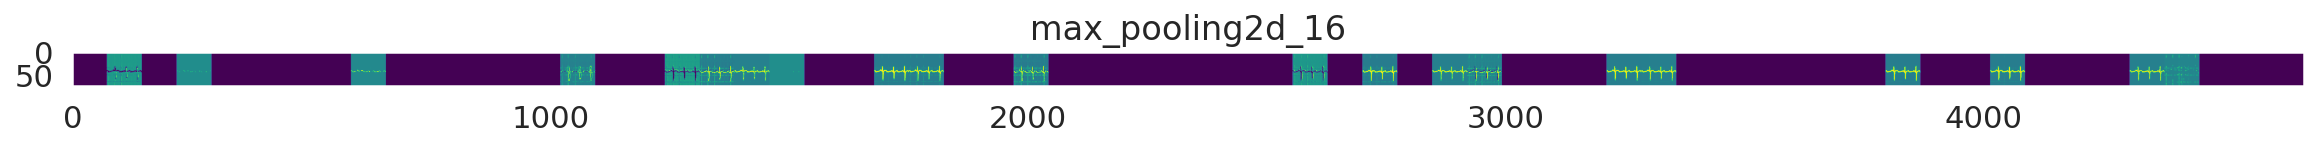

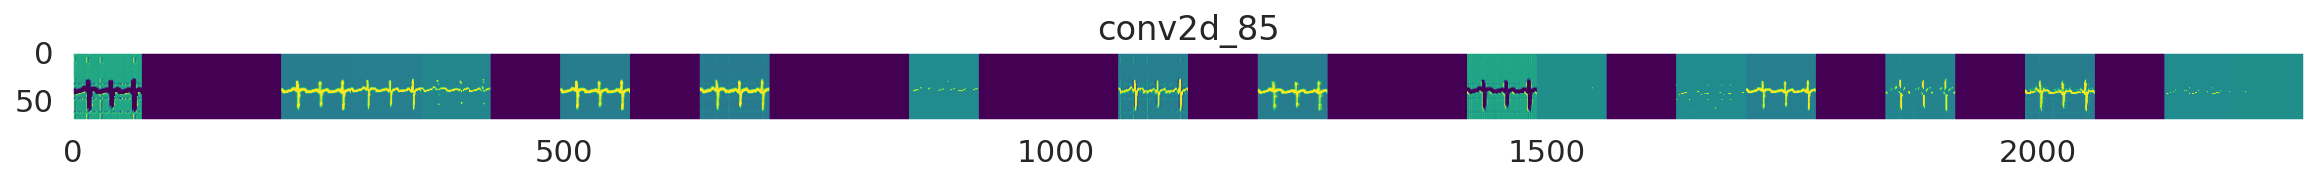

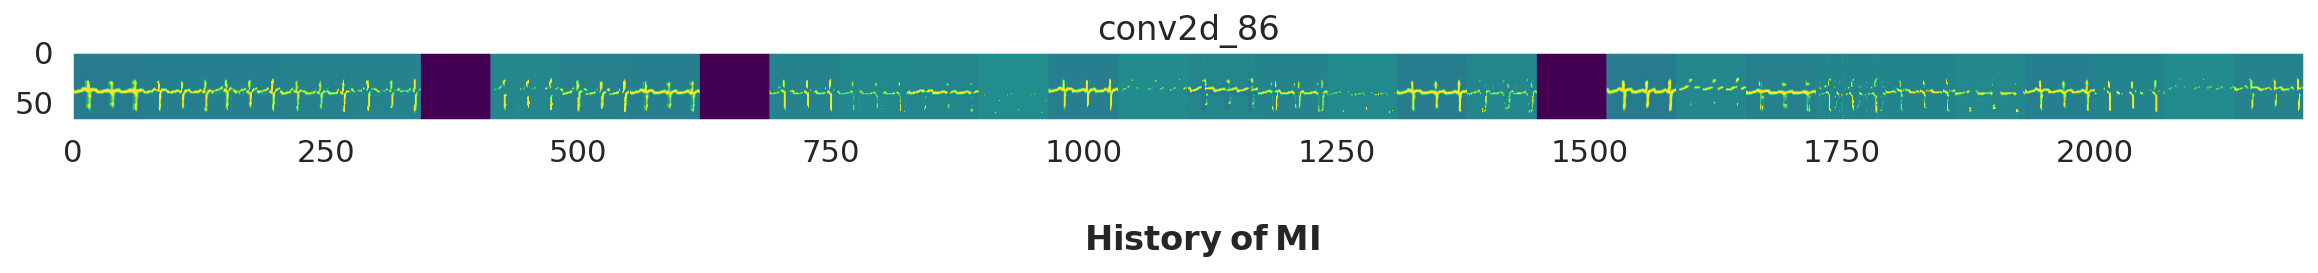

In [206]:
showfeaturemap('/content/MyDrive/MyDrive/ECG/data_v2/ECGImagesofPatientthathaveHistoryofMI/Cropped_Images/PMI_20Cropped_lead4.png')
plt.text(1000,200,r"$\bf{History\: of\: MI}$")
plt.show()

# **Helper Function with user input: Image and Label if present and output: Model Prediction Label**

In [230]:
def model_prediction(img_path="/content/MyDrive/MyDrive/ECG/data_v2/NormalPersonECGImages/Cropped_Images/Normal_100Cropped_lead4.png"):
  img = image.load_img(img_path, grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True
  plt.imshow(img)
  img = image.img_to_array(img)
  img = img/255
  img = np.reshape(img,(1,150,150,1))
  img_pred = model.predict(img)  
  img_label = np.argmax(img_pred, axis=1)
  # print(img_label)
  if img_label == 0:
    print("The model predicted this ECG to be of a person with a normal heart")
  if img_label == 1:
    print("The model predicted this ECG to be of a person having a Myocardial Infarction(heart attack).  ALERT!")
  if img_label == 2:
    print("The model predicted this ECG to be of a person with an abnormal heart beat.    ALERT!")
  if img_label == 3:
    print("The model predicted this ECG to be of a person with a history of Myocardial Infarction.   ALERT!")
  

The model predicted this ECG to be of a person having a Myocardial Infarction(heart attack).  ALERT!


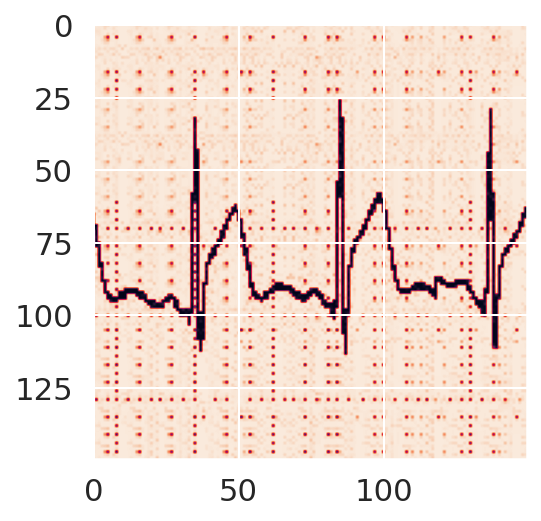

In [232]:
model_prediction("/content/MyDrive/MyDrive/ECG/data_v2/ECGImagesofMyocardialInfarctionPatients/Cropped_Images/MI_20Cropped_lead4.png")